In [45]:
%matplotlib inline
import numpy as np
import time
import math
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

import scipy as sci

## a)

In [12]:
#We create a new object-class for IBVP
class BVP(object): 
    def __init__(self, x_a=0, x_b=1, y_a=0, y_b=1, ux_0=0, ux_1=0, uy_0=0, uy_1=0, RHS=0):
        
        self.ux_0 = ux_0       # left boundary condition
        self.ux_1 = ux_1       # right boundary condition
        self.uy_0 = uy_0       # Upper boundary condition
        self.uy_1 = uy_1       # Lower boundary condition
        
        self.x_a = x_a         # left side boundry for x
        self.y_a = y_a         # left side boundry for y
        self.x_b = x_b         # right side boundry for x
        self.y_b = y_b         # right side boundry for y
        
        self.RHS = RHS        # right hand side of equation
        

In [13]:
#Reuse code from lecture notes
#Plotting function 
def plot_solution(x, y, U, txt='Solution'):
    
    fig, ax = plt.subplots(figsize = (10,10), subplot_kw={"projection": "3d"})
    Y, X = np.meshgrid(x,y)
    ax.plot_wireframe(X, Y, U)
    ax.plot_surface(X,Y, U, cmap='hot')
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('Y')
    plt.ylabel('x')
    plt.title(txt);

In [14]:
#Initial condition

def ux_0(x,y):      #Y=0
    return np.sin(np.pi*x)*np.sin(np.pi*y)
    
def ux_1(x,y):      #Y=1
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def uy_0(x,y):      #X=0
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def uy_1(x,y):      #X=1
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def RHS(x,y,a,h,k):     # Right hand side
    r=k/h
    return -(np.pi**2*a*r*np.cos(np.pi*x)*np.cos(np.pi*y)-np.pi**2*(a+1)*np.sin(np.pi*x)*np.sin(np.pi*y)-np.pi**2*r**2*np.sin(np.pi*x)*np.sin(np.pi*y))


def analyticSol(x,y): 
    return x**2*np.cos(5*y)

def RHS_2(x,y,a,h,k): #Right hand side
    r=k/h
    return -(2*(a+1)*np.cos(5*y) - 20*r*x*np.sin(5*y) - 25*r**2*x**2*np.cos(5*y))

In [15]:
#Reuse code from lecture notes

def grid(BVP,M,N): 
    
    #Input: Initial boundry problem, number of nodes in x and y direction
    #Output: Stepsize in x and y direction, 2 d array of interior gridpoints, shape of solution
        
    x = np.linspace(BVP.x_a, BVP.x_b, M+1,endpoint=True)
    y = np.linspace(BVP.y_a, BVP.y_b, N+1,endpoint=True)
    
    # these ones are valid only for this case
    # in general the radius of the smallest inscribed
    # circle should be taken
    h=x[1]-x[0] # x typical space-step
    k=y[1]-y[0] # y typical space-step
    
    # full coorindate array of INTERNAL points
    shape = [len(x[1:-1]), len(y[1:-1])]
    x, y = np.meshgrid(x[1:-1], y[1:-1])

    # reshaping so that I have columnwise vectors
    # with all the x and y coordinates. In practice, THIS passage already
    # re-order the array in a vector that follows the numbering explained
    # in the figure above
    x, y = x.flatten(), y.flatten()
    
    # array with coordinates
    coord = np.zeros((x.size,2))
    coord[:,0]=x
    coord[:,1]=y
    
    
    return h, k, coord, shape

In [16]:
#Define a function that creates a tridiagonal matrix
def tridiag(a,h,k, N, M):    
    
    A = np.zeros(((N-2)*(M-2), (N-2)*(M-2)))        #Define an 2D array we can create our matrix in
    x = np.ones((N-2)*(M-2))                        #Define an 1D array with same length as our matrix with only ones
     
    x_L=np.copy(x[1:])                              #Slice the array to fit the lower diagonal
    x_L[M-3::M-2]=0                                 #Remove every M-2 element to create adjust for the boundry gridpoints
    
    x_LL=np.copy(x[:-(M-1)])                        #Slice the array to fit the m-1 lower diagonal
    x_LL[M-3::M-2]=0                                #Remove every M-2 element to create adjust for the boundry gridpoints
    
    x_U=np.copy(x[1:])                              #Slice the array to fit the upper diagonal                   
    x_U[M-3::M-2]=0                                 #Remove every M-2 element to create adjust for the boundry gridpoints
    
    x_UU=np.copy(x[:-(M-1)])                        #Slice the array to fit the m-1 upper diagonal
    x_UU[M-3::M-2]=0                                #Remove every M-2 element to create adjust for the boundry gridpoints
    
    r=np.sqrt(k/h)
    #Use np.diag to create the A matrix
    A=np.diag(x*(2*a/h**2+2/(h**2)),0) + np.diag(x_U*(-a)/h**2,1) + np.diag(x_L*(-a)/h**2,-1) + np.diag(x_UU*(-1)/(h**2),(M-1)) + np.diag(x_LL*(-1)/(h**2),(-M+1))
    return A

In [17]:
def solver(BVP, a, M=10, N=10):
    # Input: 
    #       BVP: Boundry value problem
    #       M, N: number of grid intervals in the x- and t directions
    #       a: constant
    
    # Output: 
    #       x_grid, y_grid: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution for all grid points
    
    
    h,k,coord,shape = grid(BVP,M,N)                    #Use existing function to get a 2 d array of interiorpoints 
    U=np.zeros((N+1,M+1))                              #Define a 2 d array to save the solution in
    
    x_grid = np.linspace(BVP.x_a, BVP.x_b, M+1)        #Creating x grid
    y_grid = np.linspace(BVP.y_a, BVP.y_b, N+1)        #Creating y grid
    
    
    
    x_0_values=BVP.ux_0(x_grid,BVP.y_a)                #Defining x-valuess at y=0
    x_1_values=BVP.ux_1(x_grid,BVP.y_b)                #Defining x-valuess at y=1
    y_0_values=BVP.uy_0(BVP.x_a,y_grid)                #Defining y-valuess at x=0
    y_1_values=BVP.uy_1(BVP.x_b,y_grid)                #Defining y-valuess at y=1
    
                                                       #Plot boundry points into the solution
    U[0,:]=x_0_values                                  
    U[-1,:]=x_1_values
    U[:,0]=y_0_values
    U[:,-1]=y_1_values                                
    
    A=tridiag(a,h,k,N+1,M+1)                          #Use tridiag function to get A_h matrix
    plt.spy(A)                                        #Plot the solver matrix
    
    

    g_vec=np.zeros((M-1)*(N-1))                       #Define a vector for the "boundry adjustments"
    
    for i in range(len(g_vec)):                       #iterating through all interiorpoints to add boundry points
        
        
        if(i%(M-1)==0):                               #Adding right side boundry
            g_vec[i]+=-a*y_0_values[i//(M-1)+1] - y_0_values[i//(M-1)]
            
        elif((i+1)%(M-1)==0):                         #Adding left side boundry
            g_vec[i]+=-a*y_1_values[i//(M-1)+1] - y_1_values[i//(M-1)+2]
        
        if(i>0 and i<(M-1)):                          #Adding south boundry
            g_vec[i]+=-x_0_values[i]
            
        elif((M-1)*(N-2) <= i <= (M-1)*(N-1)-2):      #Adding north boundry
            g_vec[i]+=-x_1_values[i%(M-1)+2]
    
    f_vec=BVP.RHS(coord[:,0],coord[:,1],a,h,k)        #Define a vector for the right hand side array
    U_vec= np.linalg.solve(A,f_vec-g_vec/h**2)         #Solve the matrix problem
    U_array = np.reshape(U_vec, (N-1, M-1))           #Reshape the 1d solution array to a 2d array for interiorpoints
    
    U[1:-1,1:-1]=U_array                              #Fill in the solution vector
    #print(h,k)
    return U, x_grid, y_grid


Max error: 0.0022352764845374185 


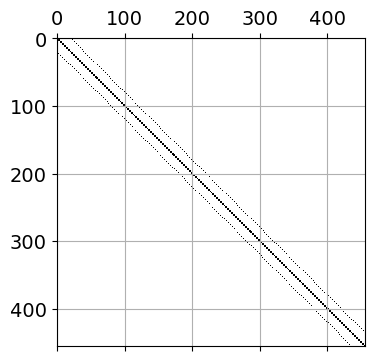

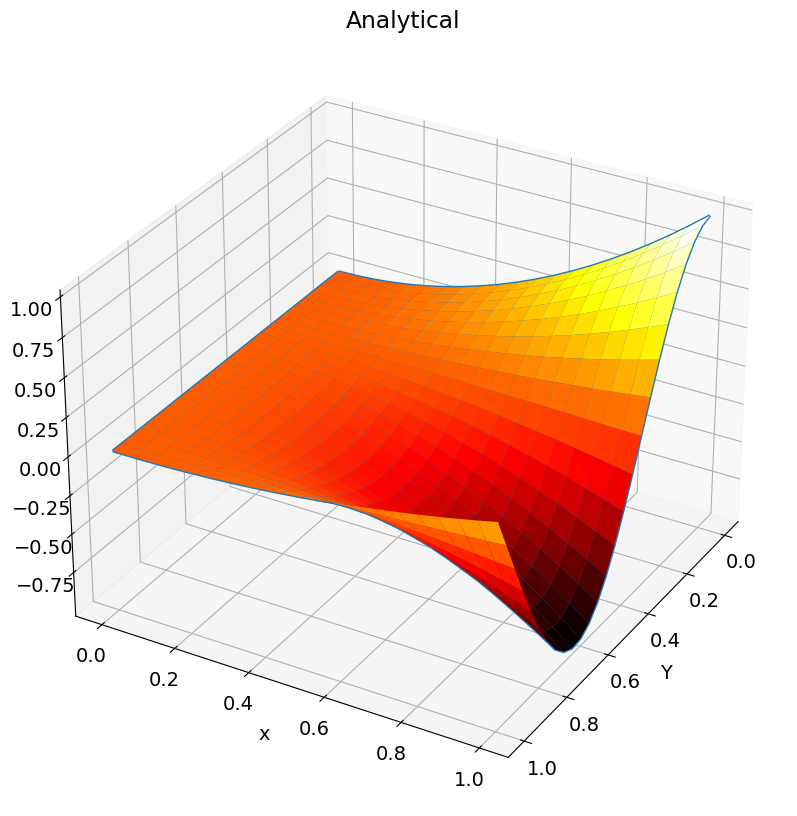

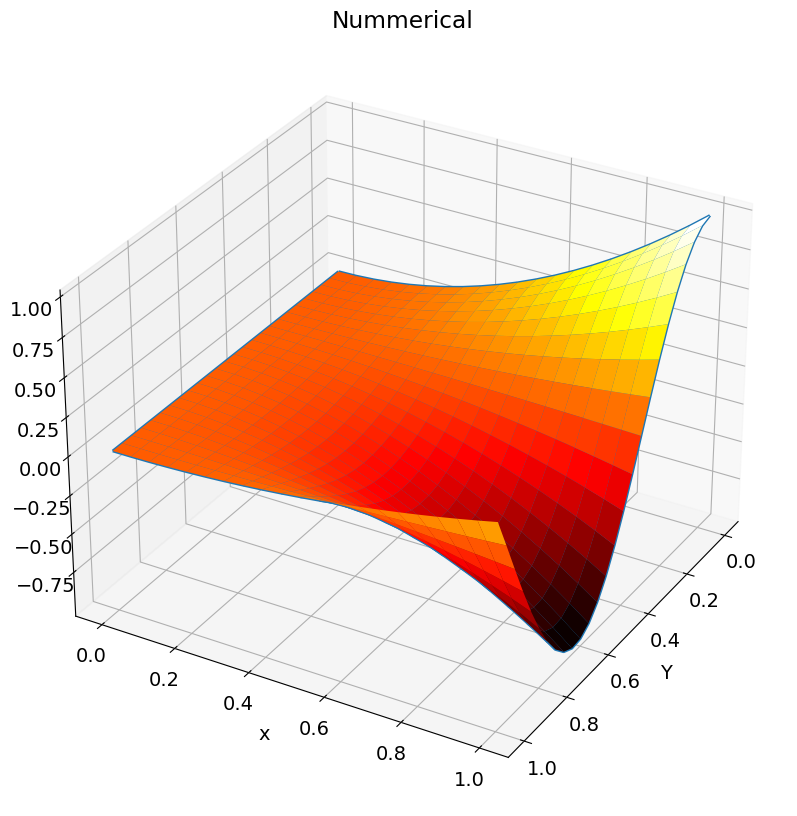

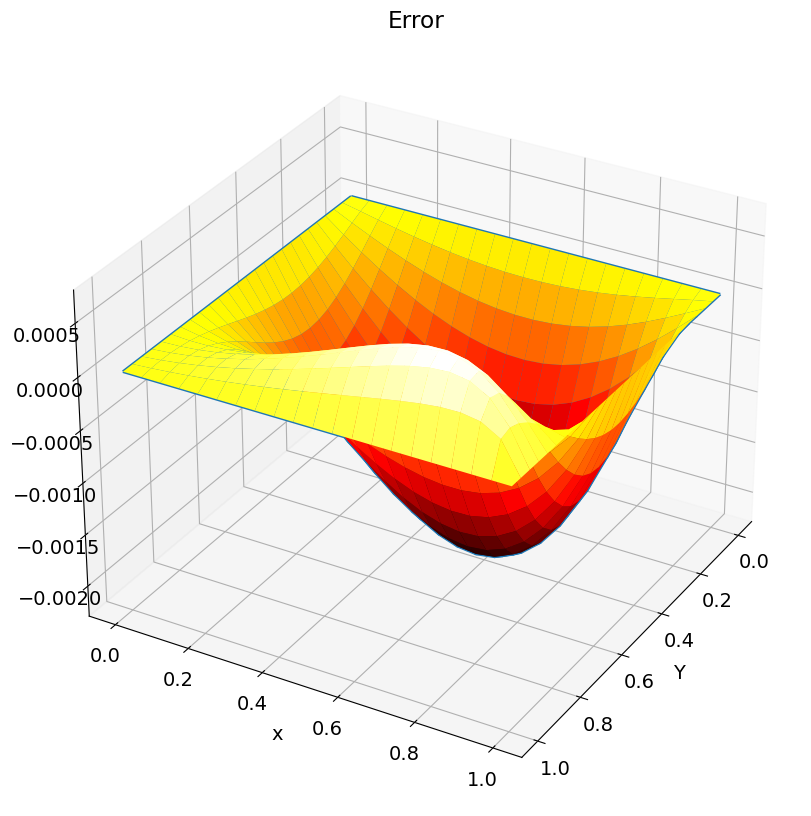

In [18]:
#Creating BVP's
a=1
test_BVP=BVP(0, 1, 0, 1, ux_0, ux_1, uy_0, uy_1, RHS)
test_BVP_2=BVP(0, 1, 0, 1, analyticSol,analyticSol,analyticSol,analyticSol,RHS_2)

#Create a nummerical and an analytical solution 
U, x_grid, y_grid=solver(test_BVP_2, a, M=20,N=25)
X, Y = np.meshgrid(x_grid,y_grid)
solution=analyticSol(X,Y)

#Plotting the solutions and the error
plot_solution(x_grid,y_grid,solution, "Analytical")
plot_solution(x_grid,y_grid,U, "Nummerical")
plot_solution(x_grid,y_grid,(solution-U), "Error")
print(f"Max error: {np.max(np.abs(solution-U))} ")

## c)

In [19]:
#Reuse convergence-tester from lecture-code. Modify it to fit our impl
def convergence_test_space(u_analytic, test_problem, solver=solver):
    a=2
    P = 5
    Hconv = np.zeros(P)
    Kconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 8
    for p in range(P):
        N=int(M/2)
        U, x, y = solver(test_problem, a, M, N)
        X, Y = np.meshgrid(x,y)
        Eh = u_analytic(X,Y)-U
        Hconv[p] = (x[1]-x[0])
        Kconv[p] = (y[1]-y[0])
        Econv[p] = np.max(np.abs(Eh))
        M = 2*M

    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Kconv, Econv, order



h          k      Error       Rate
0 0.12500000 0.25000000 0.05581583 0.00000000
1 0.06250000 0.12500000 0.01324744 2.07496097
2 0.03125000 0.06250000 0.00326929 2.01866599
3 0.01562500 0.03125000 0.00081467 2.00468027
4 0.00781250 0.01562500 0.00020370 1.99975157

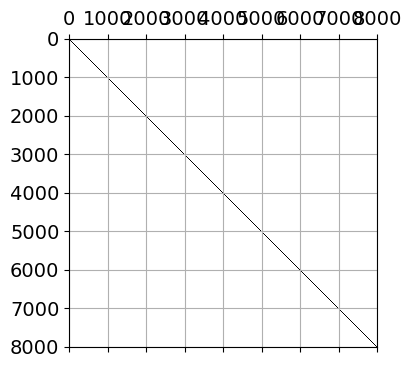

In [20]:
H, K, E, p = convergence_test_space(analyticSol, test_BVP_2, solver)
#H, E, p = convergence_test_space(uy_1, test_BVP, solver)


import pandas as pd #To format the output of the notebook.  
Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'h': H,'k':K, 'Error': E , 'Rate':Rate}) 
df

987.9983322591472


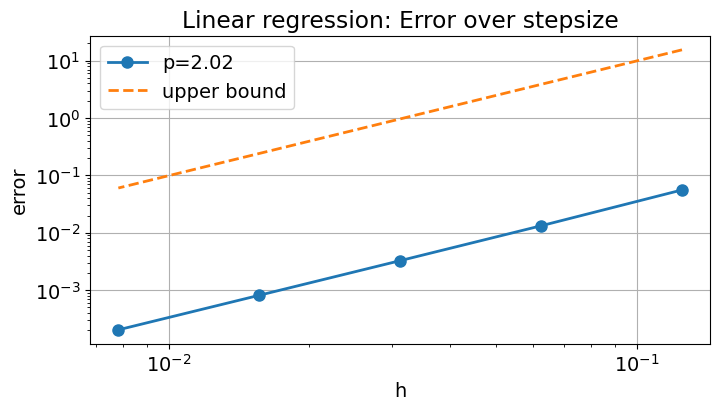

In [21]:
constant=1/4*(50*np.pi**2/4 + 250*np.pi**3/6 + 625*np.pi**4/24)
print(constant)

plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.loglog(H,constant*(H**2),'--',label='upper bound')
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title("Linear regression: Error over stepsize")
plt.legend();

## d)

We are asked to now investigate the problem with a bad direction. We want to solve the problem for an irrational $r$.
We want to solve this by using the fattening of the boundry. Since our new $r$ is irational, we can no longer adjust our upper boundry for y to be equal $1$. We are asked to define $h$ and $k$ the following way
$$
\begin{align*}
h&=\frac{1}{M} \\
k&=|r|h =\frac{1}{N}\\
\end{align*}
$$

We can combine this with our prior definitions to find the value for N
$$
\begin{align*}
N=&\frac{1}{|r|h} \\
\implies N=&\frac{M}{|r|}
\end{align*}
$$

Since $r$ is an irational number, we know that $N$ will be irational, which means we can only find an N such that we get arbitrary close to $y=1$, but never exactly $y=1$. We want $N \dot k \approx  1^+$, so we always get a value above $Y=1$ as our upper boundry.


In [22]:
def analyticSol_d(x,y): 
    return x**2*np.cos(5*y)

def RHS_d(x,y,a,h,k): #Right hand side
    r=k/h
    return -(2*(a+1)*np.cos(5*y) - 20*r*x*np.sin(5*y) - 25*r**2*x**2*np.cos(5*y))

In [23]:
def solver_d(BVP, a, r, M=10, value=False):
    # Input: 
    #       BVP: Boundry value problem
    #       M, N: number of grid intervals in the x- and t directions
    #       a: constant
    
    # Output: 
    #       x_grid, y_grid: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution for all grid points
    
    N=int(np.ceil(M/np.abs(r)))                         #Use the derived formula for y_maks with the np.ceil funtion to round the value up                 
    BVP.y_b=np.abs(r)*(1/M)*N                           #Redefine our y_maks value 
    
    h,k,coord,shape = grid(BVP,M,N)                     #Use existing function to get a 2 d array of interiorpoints 
    U=np.zeros((N+1,M+1))                               #Define a 2 d array to save the solution in
    
    x_grid = np.linspace(BVP.x_a, BVP.x_b, M+1)         #Creating x_grid
    y_grid = np.linspace(BVP.y_a, BVP.y_b, N+1)         #Creating y_grid
    
    if(value):                                          #If we solve with methode 2
        y_grid[-1]=1
    
    x_0_values=BVP.ux_0(x_grid,BVP.y_a)                 #Defining x-valuess at y=0
    y_0_values=BVP.uy_0(BVP.x_a,y_grid)                 #Defining y-valuess at x=0
    y_1_values=BVP.uy_1(BVP.x_b,y_grid)                 #Defining y-valuess at x=1
    x_1_values=BVP.ux_1(x_grid,BVP.y_b)                 #Defining x-valuess at y=y_maks
    x_1_values_mod=BVP.ux_1(x_grid,1)                   #Define x-values at y=1  
    
                                                        #Add boundry points into the solution    
    U[:,0]=y_0_values                                 
    U[:,-1]=y_1_values
    U[0,:]=x_0_values
    U[-1,:]=x_1_values_mod                              #Use values for y=1  

    A=tridiag(a,h,k,N+1,M+1)                            #Creating an A_h matrix
    #plt.spy(A)
    
    

    g_vec=np.zeros((M-1)*(N-1))                         #Define a vector for the "boundry adjustments"
    
    for i in range(len(g_vec)):                         #iterating through all interiorpoints to add boundry points
        
        if(i%(M-1)==0):                                 #Adding right side boundry
            g_vec[i]+=-a*y_0_values[i//(M-1)+1] - y_0_values[i//(M-1)]
            
        elif((i+1)%(M-1)==0):                           #Adding left side boundry
            g_vec[i]+=-a*y_1_values[i//(M-1)+1] - y_1_values[i//(M-1)+2] 
        
        if(i>0 and i<(M-1)):                            #Adding south boundry
            g_vec[i]+=-x_0_values[i]
            
        elif((M-1)*(N-2) <= i <= (M-1)*(N-1)-2):        #Adding north boundry
            if(value):
                 g_vec[i]+=-x_1_values_mod[i%(M-1)+2]
            else:
                g_vec[i]+=-x_1_values[i%(M-1)+2]
    

    f_vec=BVP.RHS(coord[:,0],coord[:,1],a,h,k)          #Define a vector for the right hand side array
    U_vec=np.linalg.solve(A,f_vec-g_vec/(h**2))         #Solve the matrix problem
    U_array = np.reshape(U_vec, (N-1, M-1))             #Reshape the 1d solution array to a 2d array for interiorpoints
    
    U[1:-1,1:-1]=U_array                                #Fill in the solution vector
    
    if(not value):                                         #If we use methode 1
        y_grid[-1]=1                                    #Create the grid so that the y_maks = 1
    
    return U, x_grid, y_grid


Max error: 0.0011618701586443292 


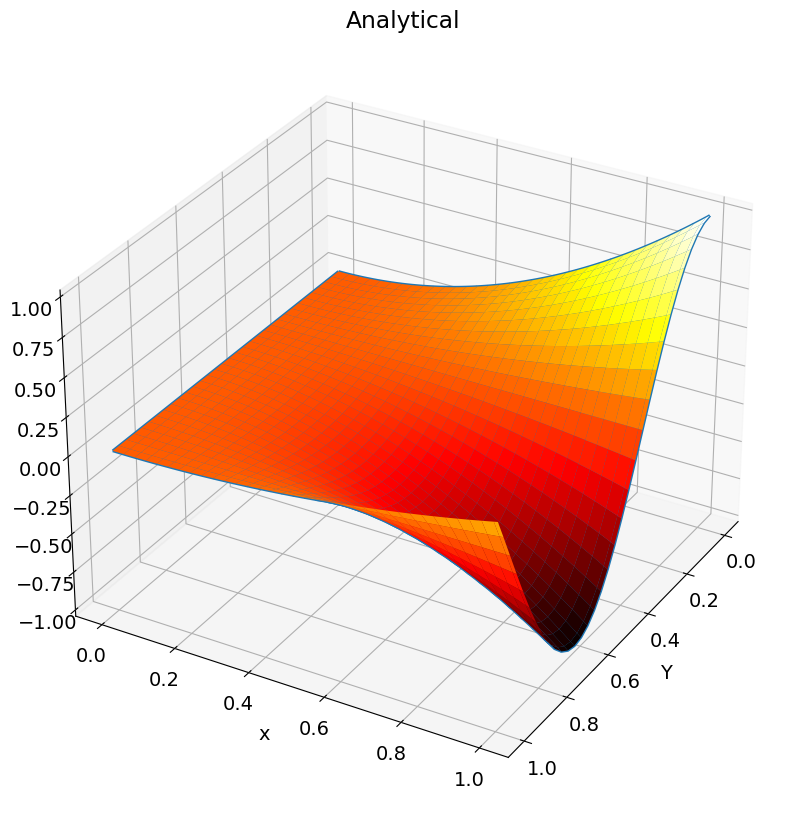

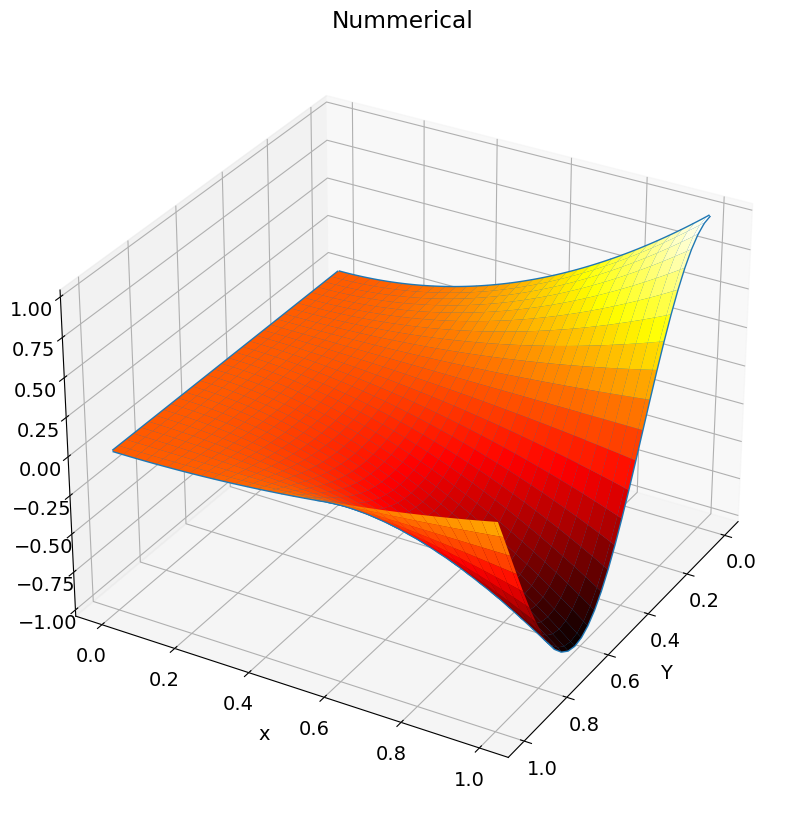

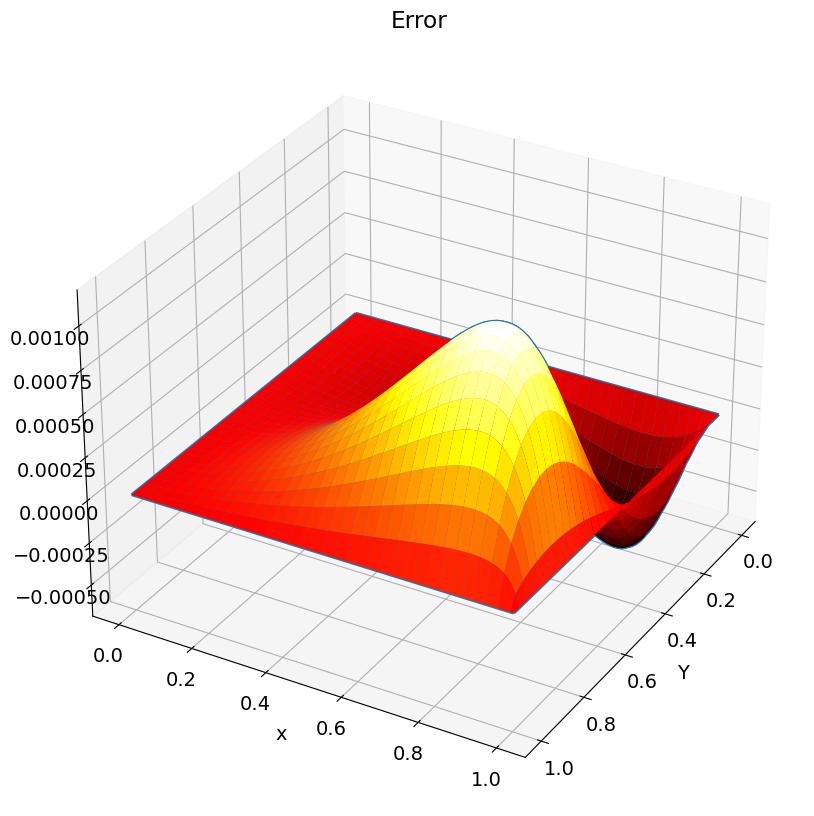

In [24]:
a=2
r=np.pi

test_BVP_d=BVP(0, 1, 0, 1, analyticSol_d,analyticSol_d,analyticSol_d,analyticSol_d,RHS_d)
U_d, x_grid, y_grid = solver_d(test_BVP_d, a, r, M=100)

X, Y = np.meshgrid(x_grid,y_grid)
solution=analyticSol_d(X,Y)



plot_solution(x_grid,y_grid,solution, "Analytical")
plot_solution(x_grid,y_grid,U_d, "Nummerical")
plot_solution(x_grid[:],y_grid,(solution-U_d), "Error")
print(f"Max error: {np.max(np.abs(solution-U_d))} ")

In [25]:
#Reuse convergence-tester from lecture-code 

def convergence_test_space_d(u_analytic, test_problem, solver=solver):
    r=np.pi
    a=2
    P = 40
    Hconv = np.zeros(P)
    Kconv = np.zeros(P)
    Econv = np.zeros(P)
    for p in range(P):
        U, x, y = solver(test_problem, a,r, 20+p)
        X, Y = np.meshgrid(x,y)
        Eh = u_analytic(X,Y)-U
        Hconv[p] = (x[3]-x[2])
        Kconv[p] = (y[3]-y[2])
        Econv[p] = np.max(np.abs(Eh))

    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Kconv, Econv, order


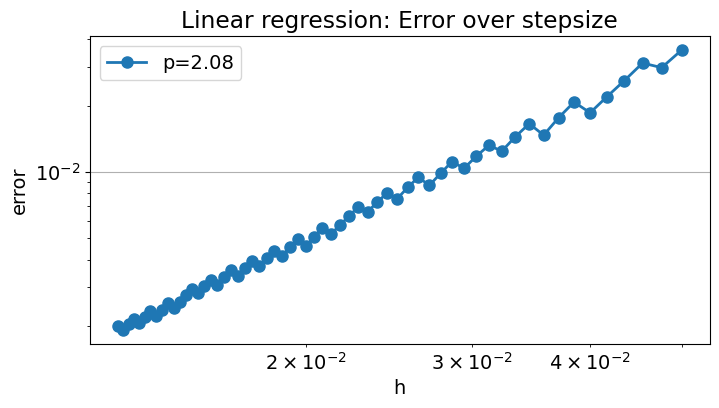

In [26]:
test_BVP_d=BVP(0, 1, 0, 1, analyticSol_d,analyticSol_d,analyticSol_d,analyticSol_d,RHS_d)
H_d, K_d, E_d, p_d = convergence_test_space_d(analyticSol_d, test_BVP_d, solver_d)

plt.loglog(H_d,E_d,'o-', label='p={:.2f}'.format(p_d))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title("Linear regression: Error over stepsize")
plt.legend();

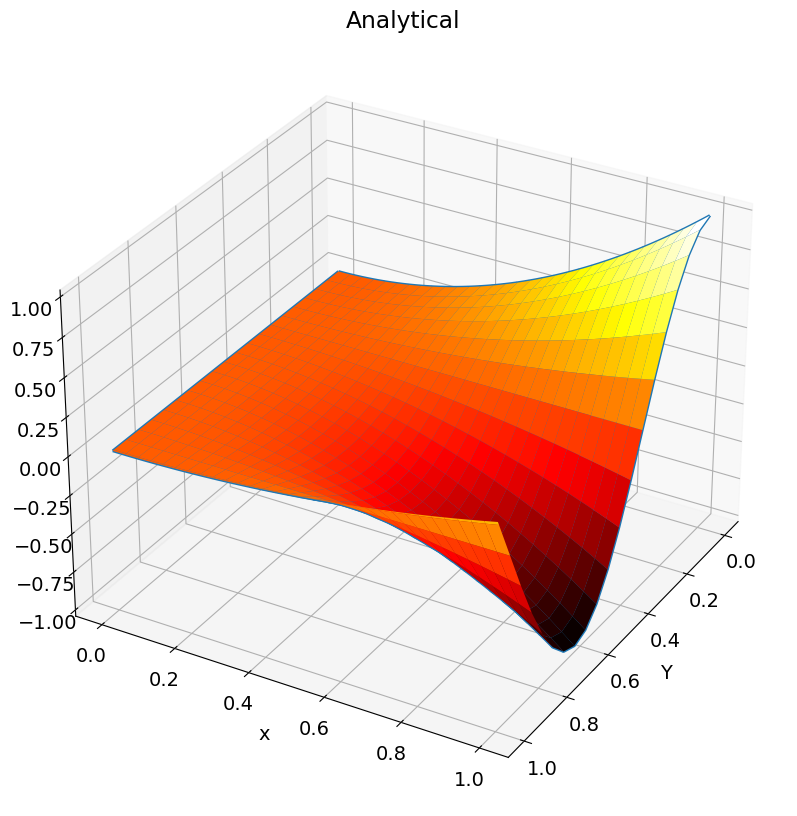

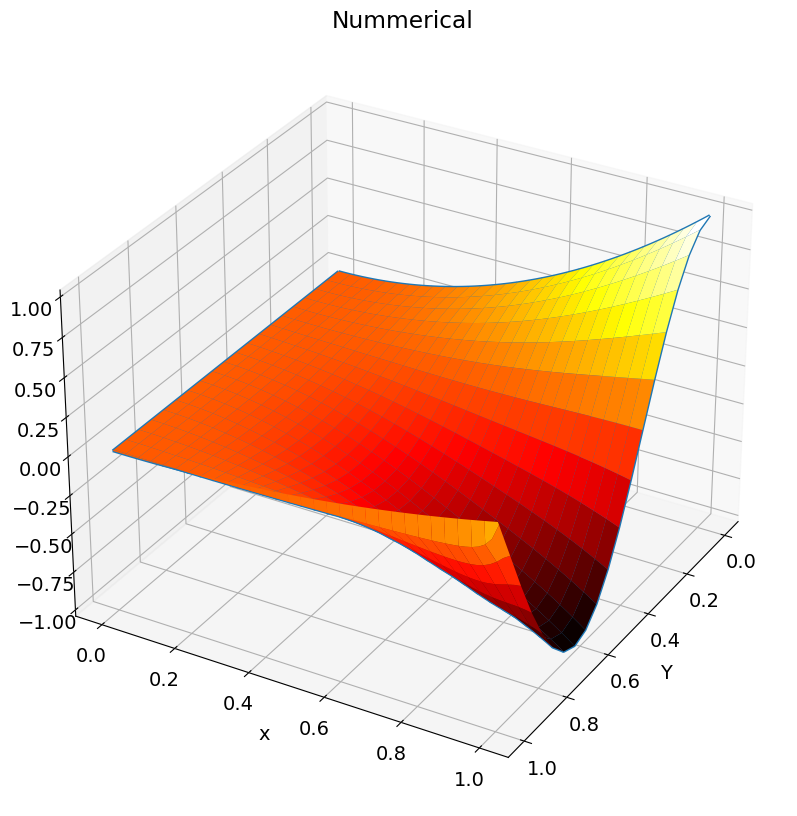

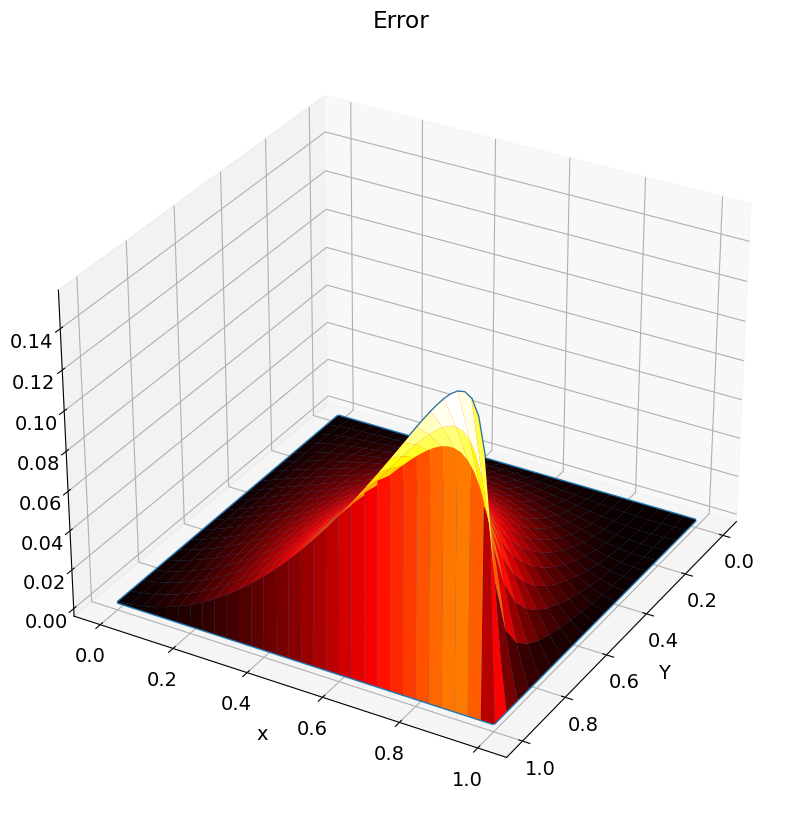

In [27]:
a=2
r=np.pi

test_BVP_d_2=BVP(0, 1, 0, 1, analyticSol_d,analyticSol_d,analyticSol_d,analyticSol_d,RHS_d)
U_d, x_grid, y_grid = solver_d(test_BVP_d, a, r, M=60, value=True)

X, Y = np.meshgrid(x_grid,y_grid)
solution=analyticSol_d(X,Y)



plot_solution(x_grid,y_grid,solution, "Analytical")
plot_solution(x_grid,y_grid,U_d, "Nummerical")
plot_solution(x_grid[:],y_grid,(solution[:,:]-U_d[:,:]), "Error")

In [28]:
#Reuse convergence-tester from lecture-code 

def convergence_test_space_d(u_analytic, test_problem,P, solver=solver):
    a=2
    Hconv = np.zeros(P)
    Kconv = np.zeros(P)
    Econv = np.zeros(P)
    Yconv = np.zeros(P)
    for p in range(P):
        U, x, y = solver(test_problem, a,r, 8+p, value=True)
        X, Y = np.meshgrid(x,y)
        Eh = u_analytic(X,Y)-U
        Hconv[p] = (x[3]-x[2])
        Kconv[p] = (y[3]-y[2])
        Econv[p] = np.max(np.abs(Eh))
        #if(p>P-10):
            #print(P-p)


    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Kconv, Econv , order




In [29]:
test_BVP_d=BVP(0, 1, 0, 1, analyticSol_d,analyticSol_d,analyticSol_d,analyticSol_d,RHS_d)
H_d, K_d, E_d, p_d = convergence_test_space_d(analyticSol_d, test_BVP_d, 50, solver_d)
#H, E, p = convergence_test_space(uy_1, test_BVP, solver)

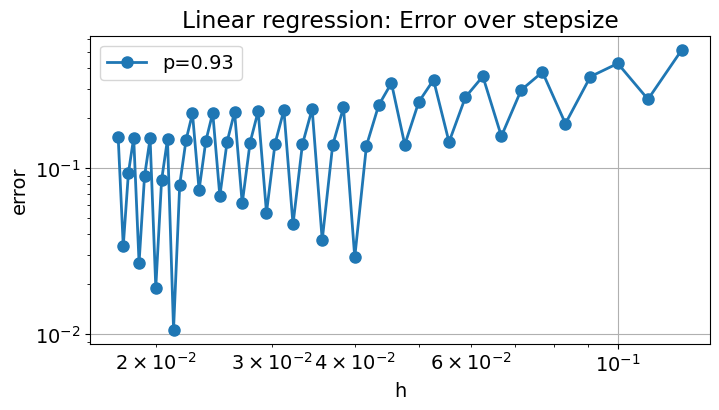

In [30]:
plt.loglog(H_d,E_d,'o-', label='p={:.2f}'.format(p_d))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title("Linear regression: Error over stepsize")
plt.legend();


In [31]:
minP=30
maxP=75
array_pvalues=np.linspace(minP,maxP,maxP-minP,endpoint=False)
array_order=np.zeros(maxP-minP)
for i in range(minP,maxP):
    if(i%5==0):
        print(i)
    H_d, K_d, E_d, p_d = convergence_test_space_d(analyticSol_d, test_BVP_d, i, solver_d)
    array_order[i-minP]=p_d

30
35
40
45
50
55
60
65
70
75
80
85


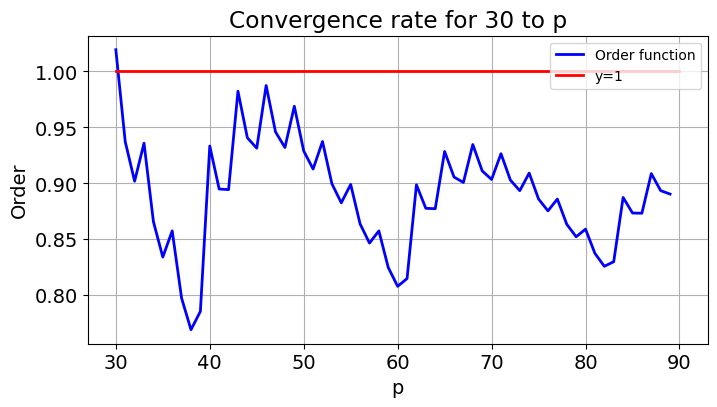

In [36]:
plt.figure()
plt.title(f"Convergence rate for {minP} to p")
plt.plot(array_pvalues,array_order,"b", label = "Order function")
plt.xlabel("p")
plt.ylabel("Order")
plt.plot((minP,maxP),(1,1), "r", label="y=1")
plt.legend(fontsize="10", loc="upper right")
plt.show()

# Code for problem 2 
Change some parts of the BVP-class and constructuon of A-matrix

In [37]:
class BVP(object): 
    def __init__(self, f, g=0, a=0, M=10, N=10):
        # right hand side (function)
        self.f = f
        # boundary conditions (function)
        self.a = a
        self.g = g
        # Numbr of subdivision along x-axis (total number of points, including boundaries)
        self.M = M
        # Numbr of subdivision along y-axis (total number of points, including boundaries)
        self.N = N

In [41]:
def grid(bvp): 
        
    x = np.linspace(0, 1.0, bvp.M)
    y = np.linspace(0, 1.0, bvp.N)
    
    # these ones are valid only for this case
    # in general the radius of the smallest inscribed
    # circle should be taken
    h=x[1]-x[0] # x typical space-step
    k=y[1]-y[0] # y typical space-step
    
    # full coorindate array of INTERNAL points
    shape = [len(x[1:-1]), len(y[1:-1])]
    x, y = np.meshgrid(x[1:-1], y[1:-1])

    # reshaping so that I have columnwise vectors
    # with all the x and y coordinates. In practice, THIS passage already
    # re-order the array in a vector that follows the numbering explained
    # in the figure above
    x, y = x.flatten(), y.flatten()
    
    # array with coordinates
    coord = np.zeros((x.size,2))
    coord[:,0]=x
    coord[:,1]=y
    
    return h, k, coord, shape

Boundary functions and analytical solution of the problem with irregular boundary 

In [42]:
def l(x): #boundary function 
    return 1/2*(np.cos(np.pi*x) + 1)

def l_inv(y):#inverse of boundaryb function 
    return 1/np.pi*np.arccos(2*y-1)

def u_where(x,y,l,u_sol): #analytcial solution with irregular boundary 
    return np.where(l(x) >= y, u_sol(x,y), 0)

def u_sol_4(x,y): #analytical solution 
    return np.cos(np.pi*x) * np.sin(np.pi*y)

def f_4(a, r, x, y):#right hand side 
    return -2*np.pi**2*np.cos(np.pi*x)*np.sin(np.pi*y)


## Numerical scheme for fattening boundary

In [43]:
def solve_bvp_fat_bound(bvp): 
    #Code takes a lot of inspiration from those handed out in class 

    # Retrieving the mesh sizes in the two dimensions,
    # the coordinates of the points (ordered) and the
    # shape of the array of INTERNAL points
    h, k, coord, shape = grid(bvp)
    
    # Initialization of the algebraic system
    A=sci.sparse.lil_matrix((coord[:,1].size,coord[:,1].size));
    b=np.zeros(len(coord[:,1]));
    
    # Addition of the forcing term
    b += -bvp.f(0, k/h, coord[:,0],coord[:,1])
    
    # number of internal points along x in one row
    # needed to locate the points around a chosen point
    M_int = shape[0]
    
    # tolerance in checking a node is on the boundary
    tol = 1e-10
    
    # Filling the matrix row by row (not efficient, done for educational purposes)
    for i, (x,y) in enumerate(zip(coord[:,0], coord[:,1])):
        
        # N.B.: the command enumerate(zip(coord[:,0], coord[:,1])) just bind together
        # the two columns of coord (the x and y coordinates of my internal points) so that
        # they can be used in the cycle for. In this way, when the iterator "i" is a certain number
        # the variables "x" and "y" contain the respective coordinates of the correspondin points
        # in the i-th row of the array "coord"
        
        if(l(x) < y): 
            #it test that allows for irregular grid, 
            # sets the solution outside of the grid automatically equal to zero
            A[i,i] = 1 
            b[i] = 0
            continue
    
        A[i,i] = 2./h**2+2/k**2
        
        # check if the stencil touches the left boundary
        if (math.isclose(x-h,0, abs_tol = tol)):
            
            A[i,i+1] = -1.0/h**2
            b[i] += bvp.g(x-h,y)/h**2
            
            # check it the stencil breaches the upper boundary
            if (l(x) < y+k):                
                b[i] += bvp.g(x,y+k)/k**2
            else:
                A[i,i+M_int] = -1.0/k**2
                
            # check it the stencil touches also the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):                
                b[i] += bvp.g(x,y-k)/k**2   
            else:
                A[i,i-M_int] = -1.0/k**2
        
        # check if the stencil breaches the right boundary
        elif (l(x+h) < y):
            
            A[i,i-1] = -1.0/h**2
            b[i] += bvp.g(x+h,y)/h**2
                
            
            # check if the stencil touches also the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x,y-k)/k**2
            else:
                A[i,i-M_int] = -1.0/k**2
                
            # check if the stencil breaches the upper boundary
            if (l(x) < y+k ):
                b[i] += bvp.g(x,y+k)/k**2
            else:
                A[i,i+M_int] = -1.0/k**2
                
        else:
            # the stencil can only touch the upper or lower boundary, but not the left and right
            
            A[i,i+1] = -1.0/h**2
            A[i,i-1] = -1.0/h**2
            
            # check if the stencil breaches the upper boundary
            if (l(x) < y + k):
                b[i] += bvp.g(x,y+k)/k**2
            else:
                A[i,i+M_int] = -1.0/k**2
            #check if the stencil touches the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x,y-k)/k**2
            else:
                A[i,i-M_int] = -1.0/k**2
    # Plot the structure of the assembled array            
    # Solve the linear system
    #U = np.linalg.solve(A, b)
    U = sci.sparse.linalg.spsolve(A.tocsr(), b)
    # Just flip the vector
    U = np.reshape(U,-1)

    return U, A, coord

## Numerical test for fattening boundary 

0.02564102564102564


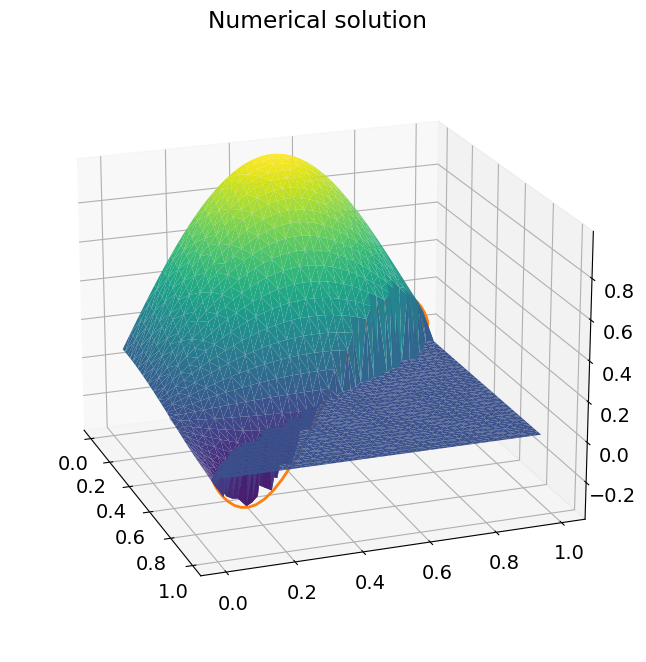

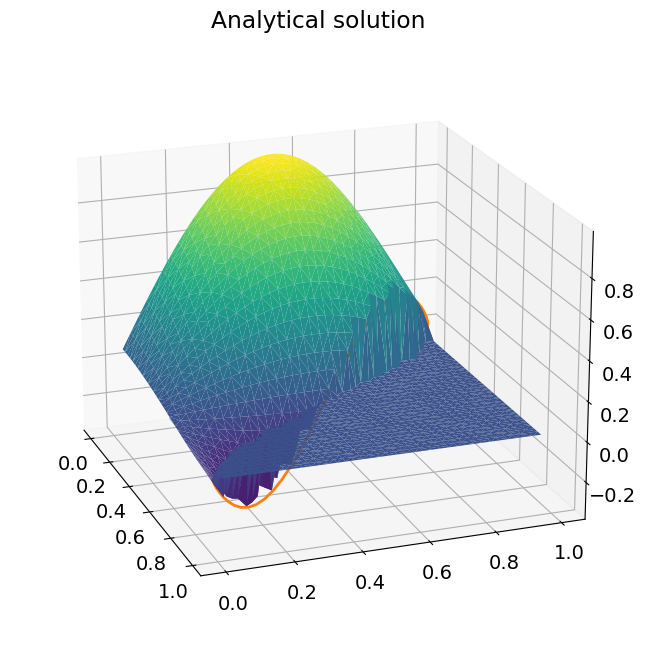

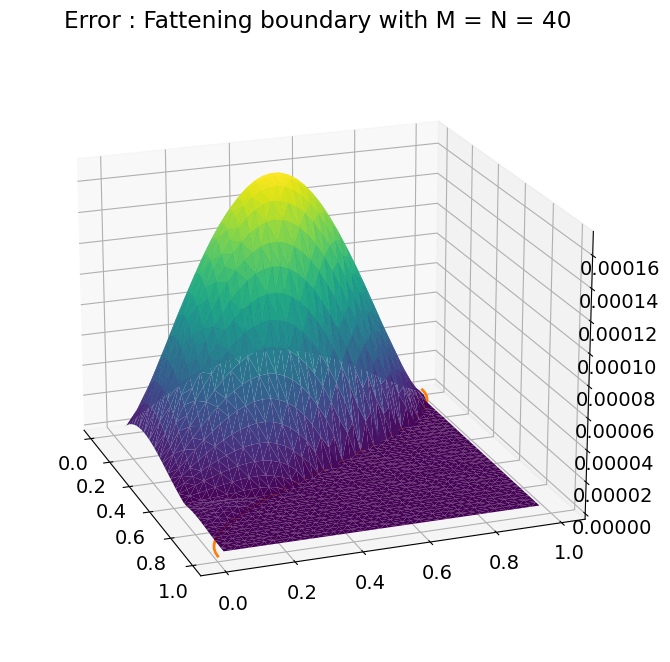

In [61]:
M = N = 40
exp2 = BVP(f_4, u_sol_4, 0, M, N)
U, A, coord = solve_bvp_fat_bound(exp2)
print(coord[1,0] - coord[0,0])
x = np.linspace(0,1, M)

plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.set_title(f'Numerical solution')
ax.plot_trisurf(coord[:,0], coord[:,1], U ,cmap='viridis')
ax.view_init(20, -20)
ax.plot(x, l(x), u_sol_4(x, l(x)))
plt.show()

plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.set_title(f'Analytical solution')
ax.plot_trisurf(coord[:,0], coord[:,1], u_where(coord[:,0],coord[:,1],l,u_sol_4),cmap='viridis', edgecolor='none')
ax.view_init(20, -20)
ax.plot(x, l(x), u_sol_4(x, l(x)))
plt.show()



plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.set_title(f'Error : Fattening boundary with M = N = {M}')
ax.plot_trisurf(coord[:,0], coord[:,1], abs(U - u_where(coord[:,0],coord[:,1],l,u_sol_4)) ,cmap='viridis')
ax.view_init(20, -20)
ax.plot(x, l(x))
plt.show()


Construct a new convergence function for irregular boundary

In [48]:
# Function operating a convergence study
def convergence2(bvp, u_exact, solver): 
    P = 5
    Hconv = np.zeros(P)
    Emax = np.zeros(P)
    M = np.copy(bvp.M)
    N = np.copy(bvp.N)
    for p in range(P):
        bvp1 = BVP(bvp.f, bvp.g, bvp.a, M,N)
        U, A, coord = solver(bvp1)
        Emax[p] = np.max(np.abs(U - u_where(coord[:,0],coord[:,1], l, u_exact)))
        Hconv[p] = coord[1,0]-coord[0,0]
        M = 2*M -2
        N = 2*N -2
    orderMax = np.polyfit(np.log(Hconv),np.log(Emax),1)[0]
    return Hconv, Emax, orderMax

## Convergence study for fattening boundary 

In [52]:
# Computation of the convergence rate
M = N = 15
a = 0
ex1 = BVP(f_4, u_sol_4, 0, M, N)
H, EM, pM = convergence2(ex1, u_sol_4, solve_bvp_fat_bound)
Rate=np.zeros(np.size(EM))
Rate[1:]=np.log10(EM[1:]/EM[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.5f}'.format
df = pd.DataFrame(data={'h': H, 'Error': EM ,'Rate':Rate}) 
df


h   Error    Rate
0 0.07143 0.00138 0.00000
1 0.03704 0.00036 2.05261
2 0.01887 0.00009 2.01457
3 0.00952 0.00002 2.00468
4 0.00478 0.00001 2.00380

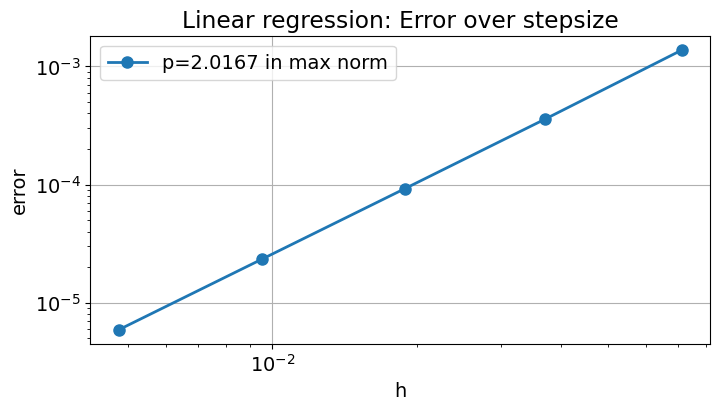

In [54]:
#plot of the convergence rate
plt.figure()
plt.loglog(H,EM,'o-', label='p={:.4f} in max norm'.format(pM))
plt.title(f'Linear regression: Error over stepsize')
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

## Numerical scheme for discretisation near the boundary 

In [62]:
def solve_bvp_change_disc(bvp):
    # Retrieving the mesh sizes in the two dimensions,
    # the coordinates of the points (ordered) and the
    # shape of the array of INTERNAL points
    h, k, coord, shape = grid(bvp)
    
    # Initialization of the algebraic system
    A=sci.sparse.lil_matrix((coord[:,1].size,coord[:,1].size));
    b=np.zeros(len(coord[:,1]));
    
    # Addition of the forcing term
    b += -bvp.f(0, k/h, coord[:,0],coord[:,1])
    
    # number of internal points along x in one row
    # needed to locate the points around a chosen point
    M_int = shape[0]
    
    # tolerance in checking a node is on the boundary
    tol = 1e-10
    tol2 = 0
    # Filling the matrix row by row (not efficient, done for educational purposes)
    for i, (x,y) in enumerate(zip(coord[:,0], coord[:,1])):
        
        # N.B.: the command enumerate(zip(coord[:,0], coord[:,1])) just bind together
        # the two columns of coord (the x and y coordinates of my internal points) so that
        # they can be used in the cycle for. In this way, when the iterator "i" is a certain number
        # the variables "x" and "y" contain the respective coordinates of the correspondin points
        # in the i-th row of the array "coord"
        
        eta_y = 1
        eta_x = 1
        
        if(l(x) <= y or l_inv(y) <= x): 
            #it test that allows for irregular grid, 
            # sets the solution outside of the grid automatically equal to zero
            A[i,i] = 1 
            b[i] = 0
            continue
    
        # check if the stencil touches the left boundary
        if (math.isclose(x-h,0, abs_tol = tol)):
            A[i,i+1] = -2/(h**2* eta_x *(1 + eta_x))
            b[i] += bvp.g(x-h,y)*2/(h**2 * (1 + eta_x))
    
            # check it the stencil breaches the upper boundary
            if (l(x) < y+k and abs(l(x) - y)/k > tol2):
                eta_y = abs(l(x)-y)/k                
                b[i] += bvp.g(x,l(x))*2/(k**2 *eta_y * (1+eta_y))
            else:
                A[i,i+M_int] = -2/(k**2 * eta_y * (1+eta_y))            

            # check it the stencil touches also the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):                
                b[i] += bvp.g(x,y-k)*2/(k**2 * (1+eta_y))
            else:
                A[i,i-M_int] = -2/(k**2 * (1+eta_y))               

        # check if the stencil breaches the right boundary
        elif (l(x+h) < y and abs(l_inv(y) - x )/h > tol2):
            eta_x = abs(l_inv(y)-x)/h
            A[i,i-1] = -2/(h**2 *(1+eta_x))
            b[i] += bvp.g(l_inv(y),y) * 2/(h**2 * eta_x *(1+eta_x))  
                
            # check if the stencil breaches the upper boundary
        
            if (l(x) < y+k and abs(l(x) - y)/k > tol2):
                eta_y = abs(l(x)-y)/k                
                b[i] += bvp.g(x,l(x)) * 2/(k**2 *eta_y * (1+eta_y))
            else:
                A[i,i+M_int] = -2/(k**2 * eta_y * (1+eta_y))
          
            # check if the stencil touches also the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x,y-k)*2/(k**2 * (1+eta_y))    
            else:
                A[i,i-M_int] = -2/(k**2 * (1+eta_y))    
        else:
            # the stencil can only touch the upper or lower boundary, but not the left and right
            
            A[i,i+1] = -2/(h**2 * eta_x *(1+eta_x))
            A[i,i-1] = -2/(h**2 * (1+eta_x))
            
            # check if the stencil breaches the upper boundary
            if (l(x) < y+k and abs(l(x) - y)/k > tol2):
                eta_y = abs(l(x)-y)/k                
                b[i] += bvp.g(x,l(x)) * 2/(k**2 * eta_y * (1+eta_y))
            else:
                A[i,i+M_int] = -2/(k**2 * eta_y * (1+eta_y))

            #check if the stencil touches the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x,y-k)* 2/(k**2 * eta_y * (1+eta_y))
            else:
                A[i,i-M_int] = -2/(k**2 *(1+eta_y))    
        A[i,i] = 2./(h**2*eta_x) + 2./(k**2*eta_y)

    # Plot the structure of the assembled array            
    # Solve the linear system
    #U = np.linalg.solve(A, b)
    U = sci.sparse.linalg.spsolve(A.tocsr(), b)
    # Just flip the vector
    U = np.reshape(U,-1)

    return U, A, coord


## Numerical test for discretisation near boundary 

0.010101010101010102 0.0001020304050607081
2.5849927792642724e-05


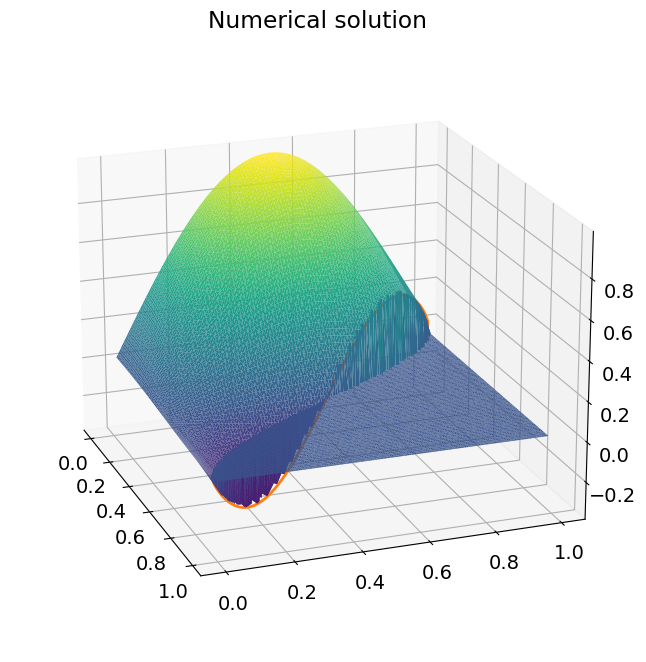

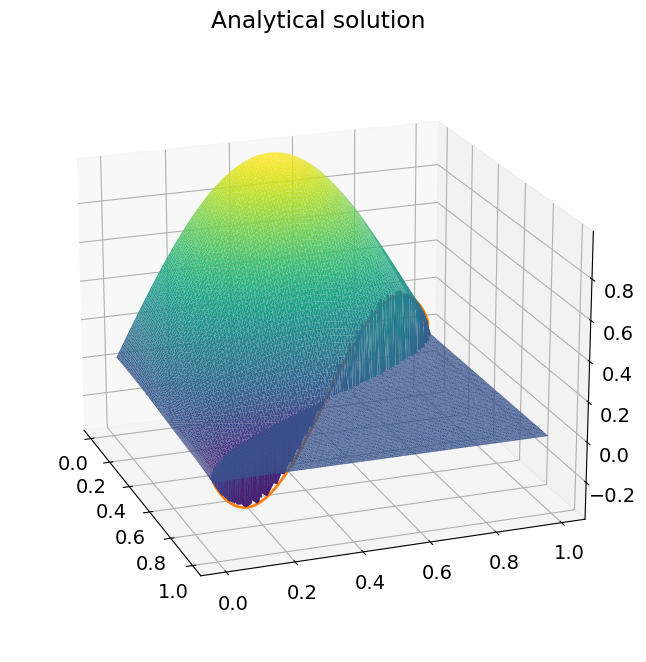

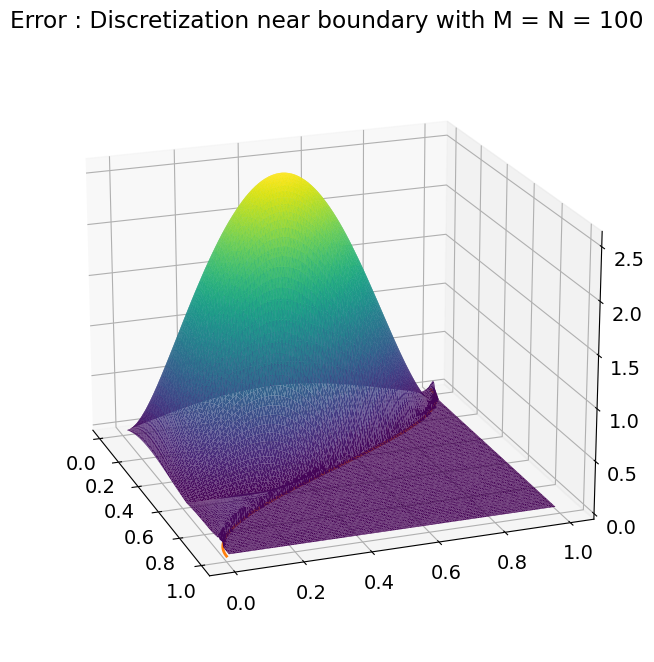

In [63]:
M = N = 100

exp2 = BVP(f_4, u_sol_4, 0, M, N)
U, A, coord = solve_bvp_change_disc(exp2)
x = np.linspace(0,1, M)

print(coord[1,0] -coord[0,0], (coord[1,0] -coord[0,0])**2)
print(np.max(abs(U - u_where(coord[:,0],coord[:,1],l,u_sol_4))))

plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.set_title(f'Numerical solution')
ax.plot_trisurf(coord[:,0], coord[:,1], U ,cmap='viridis')
ax.view_init(20, -20)
ax.plot(x, l(x), u_sol_4(x, l(x)))
plt.show()

plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.set_title(f'Analytical solution')
ax.plot_trisurf(coord[:,0], coord[:,1], u_where(coord[:,0],coord[:,1],l,u_sol_4),cmap='viridis', edgecolor='none')
ax.view_init(20, -20)
ax.plot(x, l(x), u_sol_4(x, l(x)))
plt.show()



plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.set_title(f'Error : Discretization near boundary with M = N = {M}')
ax.plot_trisurf(coord[:,0], coord[:,1], abs(U - u_where(coord[:,0],coord[:,1],l,u_sol_4)) ,cmap='viridis')
ax.view_init(20, -20)
ax.plot(x, l(x))
plt.show()


## Convergence study for discretization near boundary

In [65]:
#Computation of the convergence rates 
M = N = 20
a = 0
ex5 = BVP(f_4, u_sol_4, 0, M, N)
H, EM, pM = convergence2(ex5, u_sol_4, solve_bvp_change_disc)
Rate=np.zeros(np.size(EM))
Rate[1:]=np.log10(EM[1:]/EM[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.10f}'.format
df = pd.DataFrame(data={'h': H, 'Error': EM ,'Rate':Rate}) 
df

h        Error         Rate
0 0.0526315789 0.0006628299 0.0000000000
1 0.0270270270 0.0001806872 1.9501760736
2 0.0136986301 0.0000473369 1.9711475707
3 0.0068965517 0.0000121000 1.9876634954
4 0.0034602076 0.0000030599 1.9933788420

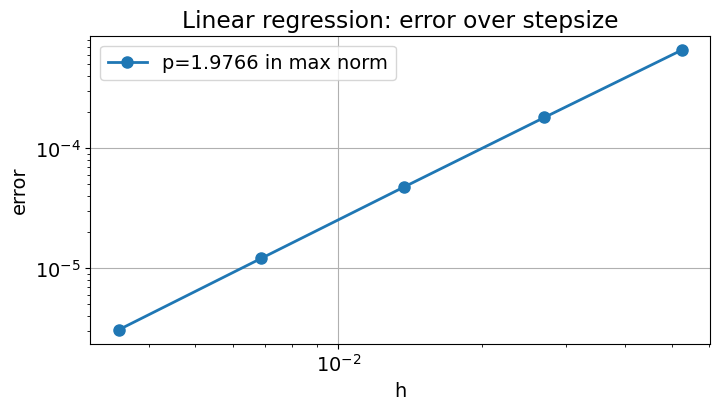

In [67]:
#Linear regression plot 
plt.figure()
plt.title(f'Linear regression: error over stepsize')
plt.loglog(H,EM,'o-', label='p={:.4f} in max norm'.format(pM))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();